# Wine Quality Analysis and Prediction using kNN Classifier built from scratch

---
## 0. Loading Libraries and Data

In [16]:
# Loading libraries
import pandas as pd
import matplotlib.pyplot as plt, matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import time
import collections
import numpy as np
import math
from IPython.display import Markdown, display
from sklearn.metrics import pairwise

COUNT = 1
DISTANCE_WEIGHTED = 2
EUCLID = 3
COSINE = 4

%matplotlib inline


def printmd(string):
    display(Markdown(string))

In [17]:
# Data load
wine = pd.read_csv('winequality-red.csv', sep = ';')

---
## 1. Converting to a Binary (Low/ High Quality) Classification Problem

      class
High    855
Low     744


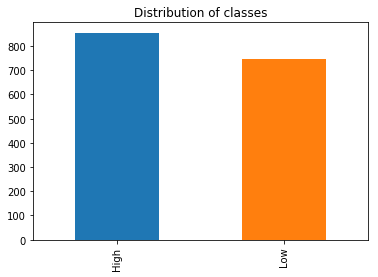

In [19]:
# Creating the class attribute
wine['class'] = ['Low' if i <= 5 else "High" for i in wine.quality]
wine['class'].value_counts().plot(kind = 'bar', title = 'Distribution of classes')

# Dropping quality attribute
wine.drop(columns = ['quality'], inplace = True)

# Paritioning dependent attributes from the independent attributes
wine_data = wine[wine.columns[wine.columns != 'class']].copy()
wine_label = wine['class'].copy()
print(pd.DataFrame(wine_label.value_counts()))

---
## 2. Preliminary Data Analysis

In [26]:
printmd('## 2.1. Data Snapshot')
wine.head()

## 2.1. Data Snapshot

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,class
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Low
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Low
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Low
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,High
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Low


In [27]:
printmd('## 2.2. Summary Statistics')
wine_data.describe()

## 2.2. Summary Statistics

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


In [28]:
printmd('## 2.3. Correlation Matrix')
wine_data.corr(method = 'pearson')

## 2.3. Correlation Matrix

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595


In [29]:
printmd('## 2.3.1 Top Correlated Pairs')
correlated_pairs = wine_data.corr()
top_correlated_pairs = correlated_pairs.unstack().sort_values(kind="quicksort")
pd.DataFrame(top_correlated_pairs[((top_correlated_pairs < -0.5) & (top_correlated_pairs > -1)) | ((top_correlated_pairs>0.5) & (top_correlated_pairs <1))], columns = ['Coefficient'])

## 2.3.1 Top Correlated Pairs

,,Coefficient
pH,fixed acidity,-0.682978
fixed acidity,pH,-0.682978
volatile acidity,citric acid,-0.552496
citric acid,volatile acidity,-0.552496
pH,citric acid,-0.541904
citric acid,pH,-0.541904
free sulfur dioxide,total sulfur dioxide,0.667666
total sulfur dioxide,free sulfur dioxide,0.667666
density,fixed acidity,0.668047
fixed acidity,density,0.668047


---
## 3. Data Transformations

In [31]:
# Dropping fixed acidity attribute
wine_data.drop(columns = ['fixed acidity','total sulfur dioxide'], inplace = True)

## Boxplot

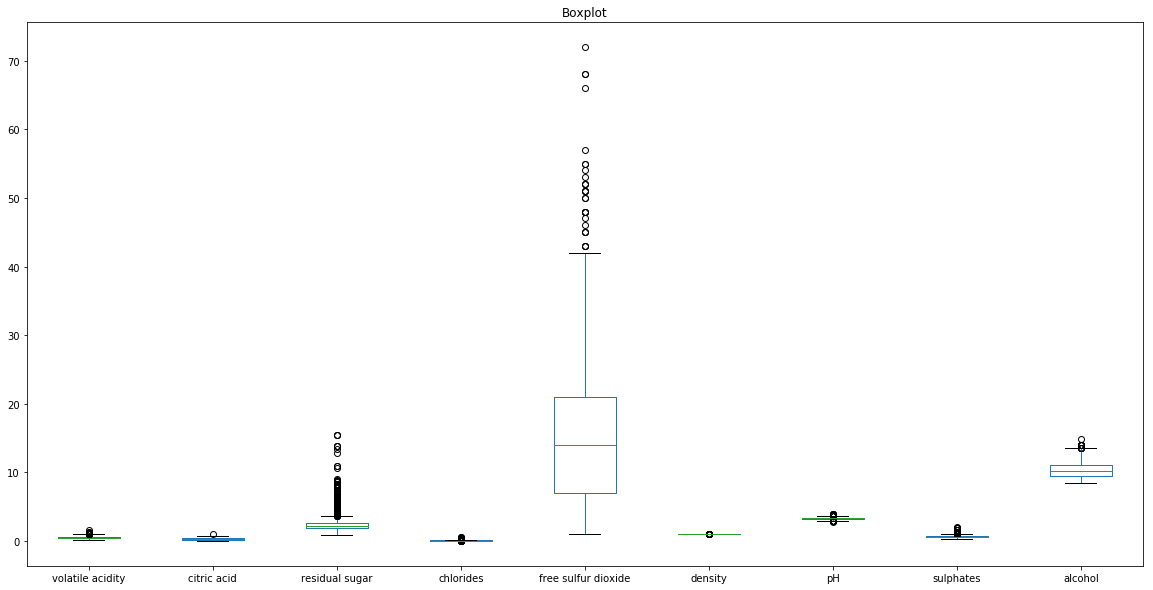

In [32]:
printmd('## Boxplot')
wine_data.plot(kind = 'box', figsize = (20,10), title = 'Boxplot')

## Outlier Analysis

### Boxplot

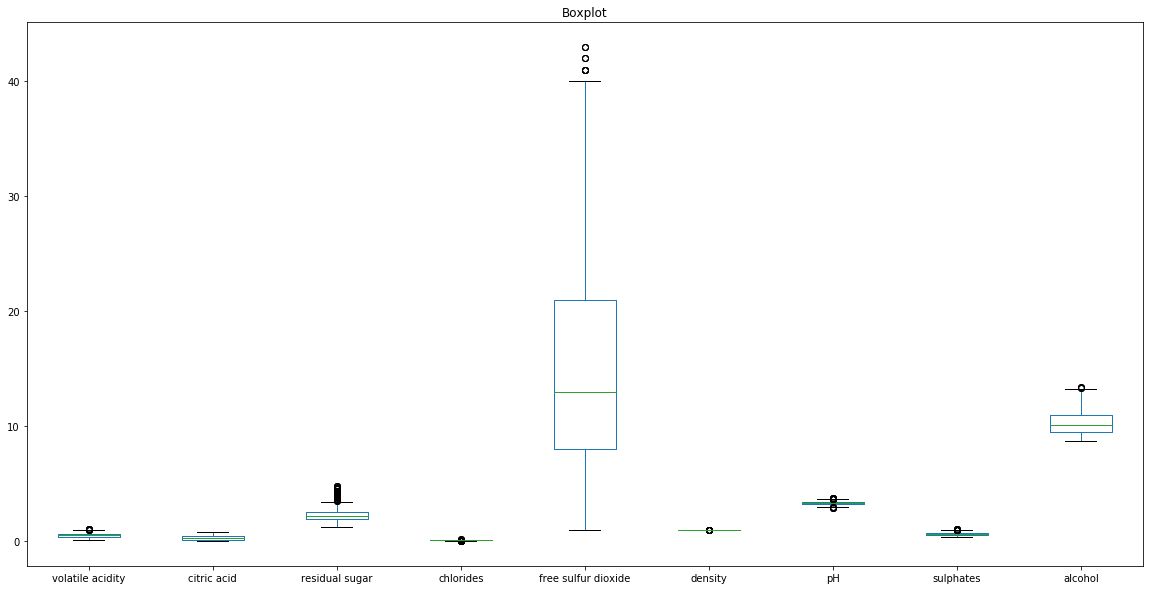

In [34]:
printmd('## Outlier Analysis')
# Removing outliers
# Keeping records where the column values are within +3/-3 standard deviations from the mean

outlier_filter = (np.abs(wine_data - wine_data.mean()) <= (3*wine_data.std())).all(1)
wine_data = wine_data[outlier_filter] 
wine_label = wine_label[outlier_filter]

printmd('### Boxplot')
wine_data.plot(kind = 'box', figsize = (20,10), title = 'Boxplot')
print()

---
## 4. Splitting data into train/test

In [36]:
X = np.array(wine_data)
y = np.array(wine_label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

---
## 5. Model Development

In [37]:
def euclidian_distance(A, B):
    if not (A.ndim == 1 and B.ndim == 1):
        raise ValueError("Both numpy arrays should be single rows (1 dimensional).")
    return np.sqrt(np.sum(np.square(A - B)))

def cosine_similarity(A, B):
    if not (A.ndim == 1 and B.ndim == 1):
        raise ValueError("Both numpy arrays should be single rows (1 dimensional).")
    return np.sum(A*B)/(np.sqrt(np.sum(A*A)) * np.sqrt(np.sum(B*B)))


def predict(train_X, labels, test, K, metric, measure):
    distances = []
    for i, sample in enumerate(train_X):
        if measure == EUCLID:
            distance = euclidian_distance(sample, test)
        elif measure == COSINE:
            distance = cosine_similarity(sample, test)
        distances.append((distance, i))

    distances.sort()

    return predict_label(distances, labels, K, metric, measure)

def predict_label(distances, labels, K, metric, measure):
    if metric == COUNT:
        k_closest = [labels[x[1]] for x in distances[:K]]
        counts = collections.Counter(k_closest)
        return counts.most_common()[0][0], counts.most_common()[0][1] / K
    if metric == DISTANCE_WEIGHTED:
        label_sum = {}
        max_sum = -1
        count = 0
        for distance, index in distances:
            if distance == 0: continue
            if count == K: break
            count += 1
            label_sum[labels[index]] = label_sum.get(labels[index], 0) + (1 / distance)
            if label_sum[labels[index]] > max_sum:
                max_sum = label_sum[labels[index]]
                predicted_label = labels[index]
        return predicted_label, max_sum / sum(label_sum.values())
    
def kNN(X_train, y_train, X_test, y_test, K, metric, measure):
    predicted = []
    for i, test in enumerate(X_test):
        predicted_class, posterior = predict(X_train, y_train, test, K, metric, measure)
        actual_class = y_test[i]
        predicted.append((actual_class, predicted_class, posterior))
    
    prediction = pd.DataFrame.from_records(predicted, columns=["Actual", "Predicted", "Posterior"])
    
    return prediction

def get_accuracy(prediction_df):
    return prediction_df[prediction_df["Actual"] == prediction_df["Predicted"]].shape[0] / prediction_df.shape[0]

In [38]:
# Maximum accuracy is found at K = 38 for the euclidian distance measure.
def optimal_K(metric, measure):
    K_candidates = range(1,50,2)
    errors = []
    for K in K_candidates:
        accuracy = get_accuracy(kNN(X_train, y_train, X_test, y_test, K, metric, measure))
        errors.append(1 - accuracy)
    
    plt.plot(K_candidates, errors)
    plt.show()
    return np.where(errors==np.min(errors))

In [39]:
def confusion_matrix(prediction_df):
    y = list(prediction_df.Actual)
    x = list(prediction_df.Predicted)
    if len(x) != len(y):
        return 'Length do not match'
    TP, TN, FP, FN = 0,0,0,0
    for i in range(len(x)):
        if y[i] == 'High':
            if x[i] == 'High':
                TP += 1
            else:
                FN += 1
        else:
            if x[i] == 'High':
                FP += 1
            else:
                TN += 1
    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    return accuracy, precision, recall, f_measure, sensitivity, specificity, error_rate

def optimal_K_confusion(metric, measure):
    K_candidates = range(1,50,2)
    out = {}
    for K in K_candidates:
        accuracy, precision, recall, f_measure, sensitivity, specificity, error_rate = confusion_matrix(kNN(X_train, y_train, X_test, y_test, K, metric, measure))
        out['K'] = out.get('K',[]) + [K]
        out['f_measure'] = out.get('f_measure',[]) + [f_measure]
        out['sensitivity'] = out.get('sensitivity',[]) + [sensitivity]
        out['specificity'] = out.get('specificity',[]) + [specificity]
        out['error_rate'] = out.get('error_rate',[]) + [error_rate]
        out['accuracy'] = out.get('accuracy',[]) + [accuracy]
        out['precision'] = out.get('precision',[]) + [precision]
        out['recall'] = out.get('recall',[]) + [recall]
        
    return pd.DataFrame(out)



---
## 6. Model Evaluation

In [42]:
printmd('### 6.1. kNN using COUNT method and Euclidean distance as proximity measure')
base_count_euclid = optimal_K_confusion(COUNT, EUCLID)
base_count_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.1. kNN using COUNT method and Euclidean distance as proximity measure

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
0,1,0.703812,0.296188,0.727763,0.703125,0.754190,0.754190,0.648148
2,5,0.703812,0.296188,0.718663,0.716667,0.720670,0.720670,0.685185
1,3,0.689150,0.310850,0.715054,0.689119,0.743017,0.743017,0.629630
5,11,0.677419,0.322581,0.696133,0.688525,0.703911,0.703911,0.648148
3,7,0.683284,0.316716,0.694915,0.702857,0.687151,0.687151,0.679012
4,9,0.674487,0.325513,0.689076,0.691011,0.687151,0.687151,0.660494
6,13,0.659824,0.340176,0.679558,0.672131,0.687151,0.687151,0.629630
18,37,0.671554,0.328446,0.676301,0.700599,0.653631,0.653631,0.691358
11,23,0.651026,0.348974,0.666667,0.668539,0.664804,0.664804,0.635802
10,21,0.648094,0.351906,0.666667,0.662983,0.670391,0.670391,0.623457


In [43]:
printmd('### 6.2. kNN using COUNT method and Cosine distance as proximity measure')
base_count_cosine = optimal_K_confusion(COUNT, COSINE)
base_count_cosine.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.2. kNN using COUNT method and Cosine distance as proximity measure

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
1,3,0.472141,0.527859,0.567308,0.497890,0.659218,0.659218,0.265432
8,17,0.475073,0.524927,0.562347,0.500000,0.642458,0.642458,0.290123
0,1,0.472141,0.527859,0.560976,0.497835,0.642458,0.642458,0.283951
10,21,0.475073,0.524927,0.560197,0.500000,0.636872,0.636872,0.296296
11,23,0.475073,0.524927,0.560197,0.500000,0.636872,0.636872,0.296296
12,25,0.475073,0.524927,0.560197,0.500000,0.636872,0.636872,0.296296
13,27,0.475073,0.524927,0.560197,0.500000,0.636872,0.636872,0.296296
16,33,0.475073,0.524927,0.560197,0.500000,0.636872,0.636872,0.296296
17,35,0.475073,0.524927,0.560197,0.500000,0.636872,0.636872,0.296296
18,37,0.475073,0.524927,0.560197,0.500000,0.636872,0.636872,0.296296


In [44]:
printmd('### 6.3. kNN using Weighted Distance method and Euclidean distance as proximity measure')
base_DW_euclid = optimal_K_confusion(DISTANCE_WEIGHTED, EUCLID)
base_DW_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.3. kNN using Weighted Distance method and Euclidean distance as proximity measure

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
2,5,0.683284,0.316716,0.701657,0.693989,0.709497,0.709497,0.654321
4,9,0.674487,0.325513,0.692521,0.686813,0.698324,0.698324,0.648148
1,3,0.668622,0.331378,0.690411,0.677419,0.703911,0.703911,0.629630
5,11,0.668622,0.331378,0.683473,0.685393,0.681564,0.681564,0.654321
11,23,0.671554,0.328446,0.681818,0.693642,0.670391,0.670391,0.672840
10,21,0.665689,0.334311,0.681564,0.681564,0.681564,0.681564,0.648148
20,41,0.671554,0.328446,0.680000,0.695906,0.664804,0.664804,0.679012
8,17,0.665689,0.334311,0.679775,0.683616,0.675978,0.675978,0.654321
18,37,0.668622,0.331378,0.678063,0.691860,0.664804,0.664804,0.672840
3,7,0.659824,0.340176,0.677778,0.674033,0.681564,0.681564,0.635802


In [45]:
printmd('### 6.4. kNN using Weighted Distance method and Cosine distance as proximity measure')
base_DW_cosine = optimal_K_confusion(DISTANCE_WEIGHTED, COSINE)
base_DW_cosine.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.4. kNN using Weighted Distance method and Cosine distance as proximity measure

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
1,3,0.472141,0.527859,0.567308,0.497890,0.659218,0.659218,0.265432
8,17,0.475073,0.524927,0.562347,0.500000,0.642458,0.642458,0.290123
0,1,0.472141,0.527859,0.560976,0.497835,0.642458,0.642458,0.283951
10,21,0.475073,0.524927,0.560197,0.500000,0.636872,0.636872,0.296296
11,23,0.475073,0.524927,0.560197,0.500000,0.636872,0.636872,0.296296
12,25,0.475073,0.524927,0.560197,0.500000,0.636872,0.636872,0.296296
13,27,0.475073,0.524927,0.560197,0.500000,0.636872,0.636872,0.296296
16,33,0.475073,0.524927,0.560197,0.500000,0.636872,0.636872,0.296296
17,35,0.475073,0.524927,0.560197,0.500000,0.636872,0.636872,0.296296
18,37,0.475073,0.524927,0.560197,0.500000,0.636872,0.636872,0.296296


In [46]:
printmd('### Normalizing the data using mix-max method')
X_train, X_test, Y_train, Y_test = train_test_split(wine_data, wine_label, test_size=0.25, random_state=42)
X_train_norm = (X_train - X_train.min()) / (X_train.max() -  X_train.min())
X_test_norm = (X_test - X_train.min()) / (X_train.max() -  X_train.min())
X_train = np.array(X_train_norm)
X_test = np.array(X_test_norm)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


### Normalizing the data using mix-max method

In [47]:
printmd('### 6.5. kNN using COUNT method and Euclidean distance as proximity measure on Normalized Data')
norm_count_euclid = optimal_K_confusion(COUNT, EUCLID)
norm_count_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.5. kNN using COUNT method and Euclidean distance as proximity measure on Normalized Data

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
0,1,0.747801,0.252199,0.766304,0.746032,0.787709,0.787709,0.703704
13,27,0.750733,0.249267,0.764543,0.758242,0.770950,0.770950,0.728395
14,29,0.744868,0.255132,0.757660,0.755556,0.759777,0.759777,0.728395
20,41,0.750733,0.249267,0.755043,0.779762,0.731844,0.731844,0.771605
1,3,0.718475,0.281525,0.752577,0.698565,0.815642,0.815642,0.611111
11,23,0.733138,0.266862,0.750685,0.736559,0.765363,0.765363,0.697531
2,5,0.724340,0.275660,0.750000,0.715736,0.787709,0.787709,0.654321
21,43,0.744868,0.255132,0.749280,0.773810,0.726257,0.726257,0.765432
3,7,0.724340,0.275660,0.748663,0.717949,0.782123,0.782123,0.660494
19,39,0.741935,0.258065,0.748571,0.766082,0.731844,0.731844,0.753086


In [48]:
printmd('### 6.6. kNN using COUNT method and Cosine distance as proximity measure on Normalized Data')
norm_count_cosine = optimal_K_confusion(COUNT, COSINE)
norm_count_cosine.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.6. kNN using COUNT method and Cosine distance as proximity measure on Normalized Data

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
3,7,0.384164,0.615836,0.509346,0.437751,0.608939,0.608939,0.135802
5,11,0.384164,0.615836,0.504717,0.436735,0.597765,0.597765,0.148148
20,41,0.372434,0.627566,0.502326,0.430279,0.603352,0.603352,0.117284
23,47,0.372434,0.627566,0.502326,0.430279,0.603352,0.603352,0.117284
24,49,0.366569,0.633431,0.497674,0.426295,0.597765,0.597765,0.111111
21,43,0.366569,0.633431,0.495327,0.425703,0.592179,0.592179,0.117284
22,45,0.363636,0.636364,0.491803,0.423387,0.586592,0.586592,0.117284
4,9,0.366569,0.633431,0.490566,0.424490,0.581006,0.581006,0.129630
2,5,0.366569,0.633431,0.485714,0.423237,0.569832,0.569832,0.141975
7,15,0.369501,0.630499,0.484412,0.424370,0.564246,0.564246,0.154321


In [49]:
printmd('### 6.7. kNN using Weighted Distance method and Euclidean distance as proximity measure on Normalized Data')
norm_DW_euclid = optimal_K_confusion(DISTANCE_WEIGHTED, EUCLID)
norm_DW_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.7. kNN using Weighted Distance method and Euclidean distance as proximity measure on Normalized Data

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
14,29,0.756598,0.243402,0.772603,0.758065,0.787709,0.787709,0.722222
12,25,0.750733,0.249267,0.768392,0.750000,0.787709,0.787709,0.709877
11,23,0.747801,0.252199,0.767568,0.743455,0.793296,0.793296,0.697531
13,27,0.750733,0.249267,0.767123,0.752688,0.782123,0.782123,0.716049
20,41,0.753666,0.246334,0.764045,0.768362,0.759777,0.759777,0.746914
9,19,0.739003,0.260997,0.761394,0.731959,0.793296,0.793296,0.679012
18,37,0.750733,0.249267,0.760563,0.767045,0.754190,0.754190,0.746914
21,43,0.750733,0.249267,0.760563,0.767045,0.754190,0.754190,0.746914
15,31,0.744868,0.255132,0.759003,0.752747,0.765363,0.765363,0.722222
19,39,0.747801,0.252199,0.757062,0.765714,0.748603,0.748603,0.746914


In [50]:
printmd('### 6.8. kNN using Weighted Distance method and Cosine distance as proximity measure on Normalized Data')
norm_DW_cosine = optimal_K_confusion(DISTANCE_WEIGHTED, COSINE)
norm_DW_cosine.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.8. kNN using Weighted Distance method and Cosine distance as proximity measure on Normalized Data

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
3,7,0.384164,0.615836,0.509346,0.437751,0.608939,0.608939,0.135802
5,11,0.384164,0.615836,0.504717,0.436735,0.597765,0.597765,0.148148
20,41,0.372434,0.627566,0.502326,0.430279,0.603352,0.603352,0.117284
23,47,0.369501,0.630499,0.501160,0.428571,0.603352,0.603352,0.111111
24,49,0.366569,0.633431,0.497674,0.426295,0.597765,0.597765,0.111111
21,43,0.366569,0.633431,0.495327,0.425703,0.592179,0.592179,0.117284
22,45,0.360704,0.639296,0.490654,0.421687,0.586592,0.586592,0.111111
4,9,0.366569,0.633431,0.490566,0.424490,0.581006,0.581006,0.129630
2,5,0.366569,0.633431,0.485714,0.423237,0.569832,0.569832,0.141975
7,15,0.369501,0.630499,0.484412,0.424370,0.564246,0.564246,0.154321


In [51]:
printmd('### 6.9. kNN with only 50% data')

wine2, wine2_n = train_test_split(wine, test_size = 0.5)
wine_data = wine2[wine2.columns[wine.columns != 'class']].copy()
wine_label = wine2['class'].copy()
X_train, X_test, Y_train, Y_test = train_test_split(wine_data, wine_label, test_size=0.25, random_state=42)
X_train_norm = (X_train - X_train.min()) / (X_train.max() -  X_train.min())
X_test_norm = (X_test - X_train.min()) / (X_train.max() -  X_train.min())
X_train = np.array(X_train_norm)
X_test = np.array(X_test_norm)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

f_base_count_euclid = optimal_K_confusion(COUNT, EUCLID)
f_base_count_euclid.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

### 6.9 kNN with only 50% data

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
13,27,0.605,0.395,0.704120,0.587500,0.878505,0.878505,0.290323
16,33,0.590,0.410,0.702899,0.573964,0.906542,0.906542,0.225806
15,31,0.595,0.405,0.701107,0.579268,0.887850,0.887850,0.258065
14,29,0.600,0.400,0.699248,0.584906,0.869159,0.869159,0.290323
23,47,0.570,0.430,0.692857,0.560694,0.906542,0.906542,0.182796
24,49,0.565,0.435,0.692580,0.556818,0.915888,0.915888,0.161290
12,25,0.595,0.405,0.692015,0.583333,0.850467,0.850467,0.301075
21,43,0.570,0.430,0.690647,0.561404,0.897196,0.897196,0.193548
22,45,0.560,0.440,0.685714,0.554913,0.897196,0.897196,0.172043
17,35,0.565,0.435,0.683636,0.559524,0.878505,0.878505,0.204301


In [53]:
printmd('### 6.10. Comparing with off the shelf KNN classifiers')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

wine_data = wine[wine.columns[wine.columns != 'class']].copy()
wine_label = wine[wine.columns[wine.columns == 'class']].copy()
wine_data.drop(columns = ['fixed acidity','total sulfur dioxide'], inplace = True)
out = {}
train_data, test_data, train_label, test_label = train_test_split(wine_data, wine_label, train_size = 0.75, test_size = 0.25, random_state = 42) 

K_candidates = range(1,50,2)
out = {}
for K in K_candidates:
    knn = KNeighborsClassifier(algorithm='auto',  metric='minkowski', 
                               metric_params=None, n_jobs=-1, n_neighbors=K, p=2,
                           weights='uniform')
    knn.fit(train_data, train_label['class']) 
    accuracy, precision, recall, f_measure, sensitivity, specificity, error_rate = confusion_matrix(pd.DataFrame({'Actual' : test_label['class'],'Predicted' : knn.predict(test_data)}))
    out['K'] = out.get('K',[]) + [K]
    out['f_measure'] = out.get('f_measure',[]) + [f_measure]
    out['sensitivity'] = out.get('sensitivity',[]) + [sensitivity]
    out['specificity'] = out.get('specificity',[]) + [specificity]
    out['error_rate'] = out.get('error_rate',[]) + [error_rate]
    out['accuracy'] = out.get('accuracy',[]) + [accuracy]
    out['precision'] = out.get('precision',[]) + [precision]
    out['recall'] = out.get('recall',[]) + [recall]
off_shelf = pd.DataFrame(out).sort_values(by = ['f_measure', 'accuracy'], ascending = False)
off_shelf

### 6.10. Comparing with off the shelf KNN classifiers

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
0,1,0.7150,0.2850,0.750000,0.730769,0.770270,0.770270,0.646067
1,3,0.6900,0.3100,0.726872,0.711207,0.743243,0.743243,0.623596
2,5,0.6825,0.3175,0.710706,0.718894,0.702703,0.702703,0.657303
3,7,0.6900,0.3100,0.707547,0.742574,0.675676,0.675676,0.707865
10,21,0.6900,0.3100,0.707547,0.742574,0.675676,0.675676,0.707865
5,11,0.6850,0.3150,0.704225,0.735294,0.675676,0.675676,0.696629
4,9,0.6800,0.3200,0.702326,0.725962,0.680180,0.680180,0.679775
13,27,0.6750,0.3250,0.696262,0.723301,0.671171,0.671171,0.679775
9,19,0.6775,0.3225,0.695035,0.731343,0.662162,0.662162,0.696629
8,17,0.6725,0.3275,0.690307,0.726368,0.657658,0.657658,0.691011


---
## 7. Overall Metrics

In [60]:
off_shelf['Model'] = 'off_shelf'
base_count_euclid['Model'] = 'base_count_euclid'
base_count_cosine['Model'] = 'base_count_cosine'
base_DW_euclid['Model'] = 'base_DW_euclid'
base_DW_cosine['Model'] = 'base_DW_cosine'
norm_count_euclid['Model'] = 'norm_count_euclid'
norm_count_cosine['Model'] = 'norm_count_cosine'
norm_DW_euclid['Model'] = 'norm_DW_euclid'
norm_DW_cosine['Model'] = 'norm_DW_cosine'
f_base_count_euclid['Model'] = 'half_data_base_count_euclid'

overall_score = pd.concat([off_shelf, base_count_euclid, base_count_cosine, base_DW_euclid, base_DW_cosine, \
                   norm_count_euclid, norm_count_cosine, norm_DW_euclid, norm_DW_cosine, f_base_count_euclid])
overall_score.sort_values(by = ['f_measure', 'accuracy'], ascending = False)

,K,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity,Model
14,29,0.756598,0.243402,0.772603,0.758065,0.787709,0.787709,0.722222,norm_DW_euclid
12,25,0.750733,0.249267,0.768392,0.750000,0.787709,0.787709,0.709877,norm_DW_euclid
11,23,0.747801,0.252199,0.767568,0.743455,0.793296,0.793296,0.697531,norm_DW_euclid
13,27,0.750733,0.249267,0.767123,0.752688,0.782123,0.782123,0.716049,norm_DW_euclid
0,1,0.747801,0.252199,0.766304,0.746032,0.787709,0.787709,0.703704,norm_count_euclid
13,27,0.750733,0.249267,0.764543,0.758242,0.770950,0.770950,0.728395,norm_count_euclid
20,41,0.753666,0.246334,0.764045,0.768362,0.759777,0.759777,0.746914,norm_DW_euclid
9,19,0.739003,0.260997,0.761394,0.731959,0.793296,0.793296,0.679012,norm_DW_euclid
18,37,0.750733,0.249267,0.760563,0.767045,0.754190,0.754190,0.746914,norm_DW_euclid
21,43,0.750733,0.249267,0.760563,0.767045,0.754190,0.754190,0.746914,norm_DW_euclid


In [ ]:
# from sklearn.metrics import roc_curve,auc
# fpr_roc, tpr_roc, thresholds = roc_curve(d.Actual, d.Posterior, pos_label=0)
# roc_auc = auc(fpr_roc, tpr_roc)

# plt.title('Receiver Operating Characteristic for Euclidean(k=9)')
# plt.plot(fpr_roc, tpr_roc, label = 'AUC = %0.4f' % roc_auc)
# plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.1,1.2])
# plt.ylim([-0.1,1.2])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()